In [1]:
from sage.all import *
import numpy as np
np.set_printoptions(threshold=np.inf)

from scipy.sparse import block_diag
from numpy.linalg import inv
from sklearn.model_selection import KFold

# Learning Min-Cut with Invariant Kernels

We aim to use a permutation invariant polynomial kernel on the eigenvalues of graphs to learn the min-cut function.

## Generating a Dataset

We generate random graphs using the Erdős–Rényi model with a fixed number of nodes and randomly chosen number of edges. From the graph, min-cut is calculated. The eigenvalues are then determined and stored along with the correct min-cut value.

In [29]:
def graph_data(n_samples : int,
               d_nodes : int):
    
    eigs = np.zeros((n_samples, d_nodes))
    min_cuts = np.zeros(n_samples)

    for i in range(n_samples):
        #print(i)
        edges = np.random.randint(1, binomial(d_nodes, 2)+1)

        G = graphs.RandomGNM(d_nodes, edges)

        M = np.array(list(G.adjacency_matrix()))
        G.add_vertices([d_nodes, d_nodes+1])
        G.add_edges([[0, d_nodes, np.inf], [d_nodes-1, d_nodes+1, np.inf]])

        min_cuts[i] = G.edge_cut(d_nodes, d_nodes+1, use_edge_labels=True)
        #print('found cut')
        eigs[i] = np.linalg.eig(M)[0]
        #print('found eigenvalues')

        if i%10 == 0:
            print(i)

        if i in [100-1, 500-1, 1000-1]:
            print(f'Done: n = {i+1}, d = {d_nodes}')
            np.savez(f'n{i+1}_d{d_nodes}.npz', x=eigs[:i+1], y=min_cuts[:i+1])

    return eigs, min_cuts
    


In [17]:
data = np.load('n100_d50.npz')

In [19]:
data['x'].shape

(100, 50)

## Permutation Invariant Kernels

In [3]:
def L(r):

    r = np.roll(r, -1)
    r[-1] = 0
    return r.astype(int)

def binomials(r, s):
    return prod([binomial(int(r[i]), int(s[i])) for i in range(r.shape[0])])

def red(r, s):
    return (r - s + L(s)).astype(int)

def gale_ryser(p, q):

    if np.sum(p) != np.sum(q):
        return False
    else:

        passed = True

        q_prime = np.array([np.count_nonzero(q >= i) for i in range(q.shape[0])])
        for j in range(q.shape[0]):
            if np.sum(q_prime[:j]) < np.sum(p[:j]):
                passed = False

        return passed
    
def comps_lessthan(k, s):

    n = s.shape[0]
    comps = WeightedIntegerVectors(k, np.ones(n))
    comps_less = []
    for comp in comps:
        if np.all(np.less_equal(comp, s)):
            comps_less.append(np.array(comp).astype(int))

    return comps_less

def un_bar(q_bar):

    q = np.concatenate(tuple([i+1 * np.ones(q_bar[i]) for i in range(q_bar.shape[0])]))
    return np.sort(q)[::-1]

def N(p , q):

    # print(f'finding number of matrices for p = {p}, q = {q}')

    if np.sum(p) != np.sum(q):
        return 0
    
    elif np.sum(p) == 0:
        return 1
    
    else:
        n = np.sum(p)

        # Check Gale-Ryser Criterion
        if gale_ryser(p, q):
            # Find vector of counts
            q_bar = np.array([np.count_nonzero(q == i) for i in range(1, n+1)]).astype(int)

            # Find compositions of p_1 less than or equal to q_bar
            comps = comps_lessthan(p[0], q_bar)

            num = 0
            for comp in comps:
                num += binomials(q_bar, comp) * N(L(p), un_bar(red(q_bar, comp)))
            return num
        
        else:
            return 0 

In [31]:
class InvariantKernel:

    def C_star(self):
        rank = len(self.parts)

        C = np.zeros((rank, rank))
        C[0][0] = 1

        for i in range(1, rank):
            part  = np.array(self.parts[i])
            size = int(np.sum(np.array(part)))

            coeff = np.prod([factorial(np.count_nonzero(part == i)) for i in range(size)]) * factorial(size)/np.prod([factorial(int(part[i])) for i in range(len(part))])
            
            C[i][i] = coeff/factorial(size)

        #print('found C*')
        return C
    
    def change_basis(self):

        blocks = []
        #print('Changing basis')

        for i in range(self.degree+1):
            P = Partitions(i).list()
            mat = np.zeros((len(P), len(P)))

            for i in range(len(P)):
                for j in range(len(P)):
                    v = N(np.array(list(P[i])), np.array(list(P[j])))
                    mat[i][j] = v
                    mat[i][j] = v

            blocks.append(mat)

        return block_diag(tuple(blocks)).toarray()
    

    def elementary_symmetric_polynomials(self, x):

        mat = np.zeros((self.degree+1, self.dimension+1))

        mat[0] = np.ones(self.dimension+1)
        
        for i in range(self.degree):
            #print(f'row {i}')
            for j in range(i, self.dimension):
                mat[i+1][j+1] = x[j]*mat[i][j] + mat[i+1][j]

        return mat[:, self.dimension]
    
    def evaluate(self, x, y):

        esp_x = self.elementary_symmetric_polynomials(x)
        esp_y = self.elementary_symmetric_polynomials(y)

        #print('ESP Computed')

        basis_x = [1]
        basis_y = [[1]]

        for i in range(1, len(self.parts)):
            part = self.parts[i]
            basis_x.append(np.prod([esp_x[p] for p in part]))
            basis_y.append([np.prod([esp_y[p] for p in part])])

        return (np.array(basis_y).T @ self.C @ np.array(basis_x))[0]
    
    def matrix(self, X, Y):

        rank = len(self.parts)

        esp_X = np.zeros((X.shape[0], self.degree + 1))
        esp_Y = np.zeros((Y.shape[0], self.degree + 1))

        for i in range(X.shape[0]):
            esp_X[i] = self.elementary_symmetric_polynomials(X[i])

        for i in range(Y.shape[0]):
            esp_Y[i] = self.elementary_symmetric_polynomials(Y[i])

        basis_X = np.zeros((rank, X.shape[0]))
        basis_Y = np.zeros((rank, Y.shape[0]))

        basis_X[0] = np.ones(X.shape[0])
        basis_Y[0] = np.ones(Y.shape[0])

        for i in range(1, len(self.parts)):
            part = self.parts[i]

            basis_X[i] = np.array([np.prod([esp_X[j][p] for p in part]) for j in range(X.shape[0])])
            basis_Y[i] = np.array([np.prod([esp_Y[j][p] for p in part]) for j in range(Y.shape[0])])

        return basis_Y.T @ self.C @ basis_X
    
    def gram_matrix(self, X):
        N = X.shape[0]
        mat = np.zeros((N, N))

        for i in range(N):
            for j in range(i, N):
                v = self.evaluate(X[i], X[j])
                mat[i][j] = v
                if j != i:
                    mat[j][i] = v

        return mat
    
    def prediction_matrix(self, X, Y):

        return self.matrix(X, Y)
    

    def predict(self, X):

        P = self.prediction_matrix(self.train_data, X)

        return P @ self.alpha

    def relative_error(self, X, Y):

        return np.sum((Y-self.predict(X))**2/(Y - np.mean(Y))**2)

    def train(self, X, y, lam):

        N = X.shape[0]
        M = self.gram_matrix(X)

        alpha = np.linalg.solve(M + lam * np.eye(N), y)

        self.alpha = alpha
        self.train_data = X
        self.training_error = self.relative_error(X, y)
    
    def mse(self, X, y):
        
        return np.mean((y - self.predict(X))**2)


    def __init__(self, d, n):
        self.degree = n
        self.dimension = d
        self.alpha = None
        self.train_data = None

        self.parts = []
        for i in range(self.degree + 1):
            self.parts.extend(Partitions(i).list())

        if n < 11:
            self.C = np.load(f'C_{n}.npy')

        else:
            B = inv(self.change_basis())
            self.C = B @ self.C_star() @ B
    
        
    

In [32]:
class Kernel:
    def evaluate(self, x, y):

        values  = [(x@y)**(i+1)/factorial(i+1) for i in range(self.degree) ]

        return 1 + np.sum(values)
    
    def gram_matrix(self, X):

        N = X.shape[0]
        mat = np.zeros((N, N))

        for i in range(N):
            for j in range(i, N):
                v = self.evaluate(X[i], X[j])
                mat[i][j] = v
                if j != i:
                    mat[j][i] = v

        return mat
    
    def prediction_matrix(self, X, Y):

        N = X.shape[0]
        M = Y.shape[0]

        mat = np.zeros((M, N))

        for i in range(M):
            for j in range(N):
                #print(f'{i}, {j}')
                mat[i][j] = self.evaluate(Y[i], X[j])

        return mat
    
    def predict(self, X):

        P = self.prediction_matrix(self.train_data, X)

        return P @ self.alpha

    def relative_error(self, X, Y):

        return np.sum((Y-self.predict(X))**2/(Y - np.mean(Y))**2)

    def train(self, X, y, lam):

        N = X.shape[0]
        M = self.gram_matrix(X)

        alpha = np.linalg.solve(M + lam * np.eye(N), y)

        self.alpha = alpha
        self.train_data = X
        self.training_error = self.relative_error(X, y)
    
    def mse(self, X, y):
        
        return np.mean((y - self.predict(X))**2)
    
    def __init__(self, d, n):
        self.degree = n
        self.dimension = d


## Training and Testing Kernels

For each triple ($n$, $d$, $m$) compute the error with $n$ samples in dimension $d$ with degree $m$

 - $d \in \{50, 100, 500, 1000\}$
 - $m \in \{1, 2, 3, 4, 5, 6, 7, 8, 9, 10\}$
 - $n \in \{100, 200, 300, 400, 500, 600, 700, 800, 900, 1000\}$

In [56]:
import itertools as it

In [41]:
invariant_errors = np.zeros((4, 10, 10))
non_invariant_errors = np.zeros((4, 10, 10, 5))

In [53]:
dims = [50, 100, 500, 1000]
degs = list(range(1, 11))
n_samples = list(range(100, 1001, 100))
lams = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
folds  = 5

kfold = KFold(n_splits=folds)

In [ ]:
for i in range(len(dims)):

    d = dims[i]
    data = np.load(f'n1000_d{d}.npz')

    for j in range(len(n_samples)):
        n = n_samples[j]
        X = data['x'][:n]
        y = data['y'][:n]

        for k in range(len(degs)):
            m = degs[k]
            invariant_kernel = InvariantKernel(m, d)
            noninvariant_kernel = Kernel(m, d)

            invariant_val_error = np.zeros(folds)
            invariant_train_error = np.zeros(folds)

            noninvariant_val_error = np.zeros((folds, len(lams)))
            noninvariant_train_error = np.zeros((folds, len(lams)))

            fold = 0
            for train_index, test_index in kfold.split(X):
                print('fold', fold)

                N_ = len(train_index)
                M = len(test_index)

                train_data = X[train_index]
                train_values = y[train_index]
                val_data = X[test_index]
                val_values = y[test_index]

                invariant_M = invariant_kernel.gram_matrix(train_data)
                noninvariant_M = noninvariant_kernel.gram_matrix(train_data)

                

            





    

In [368]:
lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
splits = 5

rerun_mses = np.zeros((10, 5))
rerun_mses_nosym = np.zeros((10, 5))

training_mses = np.zeros((10, 5))
training_mses_nosym = np.zeros((10, 5))

In [367]:
kfold = KFold(n_splits=splits)

In [323]:
for i in range(10):
    n = i+1
    print("degree", n)

    inv_ker = InvariantKernel(50, n)
    ker = Kernel(50, n)

    val_scores = np.zeros((splits, len(lambdas)))
    val_scores_nosym = np.zeros((splits, len(lambdas)))

    train_error = np.zeros((splits, len(lambdas)))
    train_error_nosym = np.zeros((splits, len(lambdas)))

    fold = 0
    for train_index, test_index in kfold.split(X):
        print('fold', fold)

        N_ = len(train_index)
        M = len(test_index)

        train_data = X[train_index]
        train_values = y[train_index]
        val_data = X[test_index]
        val_values = y[test_index]

        M_k_inv  = inv_ker.gram_matrix(train_data)
        M_k = ker.gram_matrix(train_data)

        #print(M_k_inv.shape)

        P_k_inv = inv_ker.prediction_matrix(train_data, val_data)
        P_k = ker.prediction_matrix(train_data, val_data)

        #print(P_k_inv.shape)

        for j in range(len(lambdas)):
            lam = lambdas[j]

            alpha = np.linalg.solve(M_k_inv + lam * np.eye(N_), train_values)

            preds = P_k_inv @ alpha

            alpha_nosym = np.linalg.solve(M_k + lam * np.eye(N_), train_values)
            preds_nosym = P_k @ alpha_nosym

            mse = np.mean((preds - val_values)**2)
            mse_nosym =  np.mean((preds_nosym - val_values)**2)

            val_scores[fold][j] = mse
            val_scores_nosym[fold][j] = mse_nosym

            train_error[fold][j] = inv_ker.training_error


        fold += 1

    rerun_mses[i] = np.mean(val_scores, axis=1)
    rerun_mses_nosym[i] = np.mean(val_scores_nosym, axis=1)
    print(rerun_mses)
    print(rerun_mses_nosym)

degree 1
fold 0
fold 1
fold 2
fold 3
fold 4
[[180.44238146 195.50513308 214.3345283  198.34693595 204.85405897]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]]
[[8.55079936 5.95863399 4.85403163 6.75418956 6.56031217]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.      

In [324]:
mses

array([[2.91102779e+02, 1.98291785e+02, 2.19398469e+02, 2.27028052e+02,
        2.04574808e+02],
       [9.74017904e+00, 2.92830665e+01, 2.93841895e+01, 2.96051790e+01,
        3.01064312e+01],
       [1.25740944e+02, 2.29102421e+01, 2.61260065e+01, 2.69375083e+01,
        2.39499560e+01],
       [2.16451649e+11, 2.62512801e+10, 9.67229652e+10, 7.30393913e+10,
        6.47901826e+10],
       [2.17195684e+22, 8.60793166e+21, 7.91168984e+21, 1.10949138e+22,
        1.01476728e+22],
       [8.37931820e+32, 4.07616700e+33, 3.55789358e+33, 5.37264379e+33,
        4.07043545e+33],
       [9.69691724e+37, 1.42460259e+37, 1.63266182e+37, 1.30067841e+37,
        1.51738675e+37],
       [1.32529495e+47, 2.69165219e+44, 2.30756332e+44, 2.71219101e+44,
        2.48263203e+44],
       [4.75180703e+52, 9.38201192e+47, 1.01277729e+48, 9.10353299e+47,
        1.14836979e+48],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]])

In [325]:
mses_nosym

array([[4.45894504e+20, 1.07892081e+20, 1.19171426e+20, 1.26032551e+20,
        1.37785822e+20],
       [4.07531341e+25, 1.76109237e+25, 2.11857301e+25, 2.51779020e+25,
        2.25592894e+25],
       [3.85316857e+30, 8.04336077e+29, 1.15079687e+30, 1.07453176e+30,
        9.30820105e+29],
       [6.76819380e+36, 2.79094910e+37, 2.91191843e+37, 7.54520121e+36,
        2.47664205e+39],
       [1.44730706e+40, 2.74992377e+39, 1.11690250e+41, 3.87706024e+39,
        4.25322934e+39],
       [1.07723034e+42, 7.79486012e+41, 5.69441004e+41, 5.55427753e+42,
        8.97354948e+42],
       [2.78074390e+43, 6.32121244e+43, 1.42434522e+44, 3.11031255e+44,
        3.09473411e+44],
       [1.62751157e+46, 7.33859403e+44, 1.92449310e+45, 7.02824989e+45,
        2.06055404e+46],
       [1.64315265e+49, 1.14074867e+48, 2.58119667e+47, 1.47012002e+48,
        1.14631654e+48],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]])

In [326]:
import matplotlib.pyplot as plt

In [328]:
best_mses = [np.min(rerun_mses[i]) for i in range(10)]
best_lams = [lambdas[np.argmin(rerun_mses[i])] for i in range(10)]

best_mses_nosym = [np.min(rerun_mses_nosym[i]) for i in range(10)]
best_lams_nosym = [lambdas[np.argmin(rerun_mses_nosym[i])] for i in range(10)]

In [329]:
best_mses

[180.4423814642716,
 4.318606320100711,
 344.97013872753297,
 60083.46024484895,
 17883876.984410696,
 283503964.9810315,
 159992034444.8647,
 12866118818.94332,
 7995556647914.162,
 32263640742.644554]

In [331]:
best_mses_nosym

[4.854031626250708,
 48.46405704111932,
 26.590377693734098,
 51.30682421065241,
 292.3857333880067,
 2898.5828985753733,
 23449.67256387214,
 248237.13055151794,
 2349782.5416434784,
 17442160.05940907]

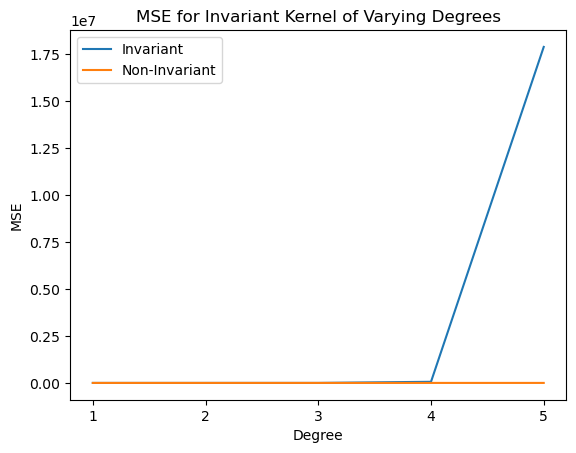

In [363]:
plt.plot(range(1,6), best_mses[:5], label = 'Invariant')
plt.plot(range(1, 6), best_mses_nosym[:5], label= 'Non-Invariant')
plt.title('MSE for Invariant Kernel of Varying Degrees')
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.xticks(range(1, 6))
plt.legend()

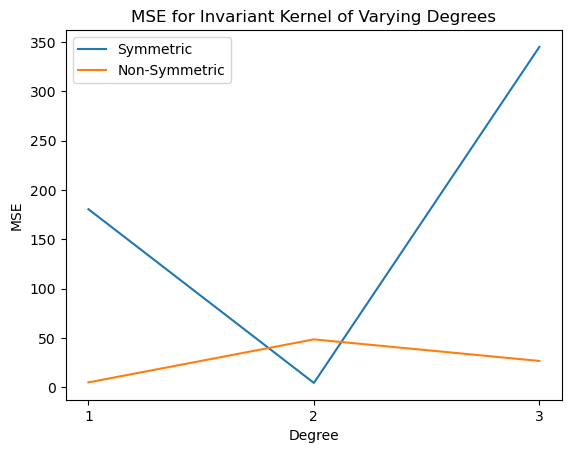

In [360]:
plt.plot(range(1,4), best_mses[:3], label = 'Invariant')
plt.plot(range(1, 4), best_mses_nosym[:3], label= 'Non-Invariant')
plt.title('MSE for Invariant Kernel of Varying Degrees')
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.xticks(range(1, 4))
plt.legend()

#for i, txt in enumerate(best_lams):
#    plt.annotate(txt, (i+1, best_mses[i]))
#for i, txt in enumerate(best_lams_nosym):
#    plt.annotate(txt, (i+1, best_mses_nosym[i]))

plt.savefig('min_cut.png')

In [268]:
best_kernel = InvariantKernel(50, 2)

In [277]:
def best_predictor(test_X, train_X, train_y, lam):

    print(test_X.shape, train_X.shape, train_y.shape)

    M_k = best_kernel.gram_matrix(train_X)
    alpha = np.linalg.solve(M_k + lam * np.eye(train_X.shape[0]), train_y)

    P_k = best_kernel.prediction_matrix(train_X, test_X)

    return P_k @ alpha

In [270]:
test_X, test_y = graph_data(100, 50)

/var/folders/jz/8fhddjfs511ft88s4zg_y4qr0000gn/T/ipykernel_21195/846028182.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  eigs[i] = np.linalg.eig(M)[0]


In [278]:
pred_y = best_predictor(test_X, X, y, 1e-5)

(100, 50) (1000, 50) (1000,)


In [279]:
np.mean((pred_y - test_y)**2)

31.23323953444138

In [280]:
test_y

array([ 0., 33., 18., 42., 16., 32., 34., 37., 14., 25., 46., 21., 14.,
       43., 29., 15., 45., 13., 42., 35., 39., 49., 15.,  7.,  0., 16.,
       27., 39., 27., 13., 46.,  1., 10.,  9., 40.,  1.,  4., 41., 11.,
        8.,  9., 27., 26.,  1., 40.,  3., 46., 27.,  5., 34., 45., 29.,
       45., 46., 26., 44., 20., 33., 36., 10., 10.,  0.,  8., 15., 43.,
       36.,  0., 34.,  8.,  9., 32., 29.,  3., 42., 41., 46., 23., 49.,
        8.,  0.,  9., 32., 20., 35., 21., 41., 18., 22., 25., 14.,  1.,
       47.,  7., 18., 19.,  6., 24., 33., 22.,  6.])

In [281]:
pred_y

array([ -9.03997803,  33.8203125 ,  10.95703125,  42.12890625,
        12.46582031,  27.3515625 ,  25.75585938,  31.3828125 ,
        11.60644531,  21.78125   ,  45.640625  ,  14.22460938,
         5.50585938,  41.83203125,  26.20898438,   8.29394531,
        42.48828125,   8.0625    ,  39.06835938,  37.31835938,
        39.91796875,  46.671875  ,  12.734375  ,   7.12109375,
       -10.26773071,  16.33984375,  26.16796875,  36.41015625,
        20.83398438,   7.1796875 ,  45.53125   ,  -7.66809082,
         4.79882812,   0.07714844,  40.15234375,  -7.80908203,
        -5.58935547,  37.3515625 ,   4.18652344,  -0.76904297,
         2.91113281,  16.1953125 ,  26.26367188,  -8.89733887,
        37.015625  ,  -4.97558594,  45.47265625,  28.76171875,
        -4.54833984,  31.16210938,  42.83203125,  26.73828125,
        44.5078125 ,  45.68359375,  22.625     ,  40.08203125,
        15.87695312,  26.63476562,  36.7578125 ,   4.61328125,
         4.84667969,  -9.74798584,   8.0625    ,   8.39

In [282]:
test_y-pred_y

array([ 9.03997803, -0.8203125 ,  7.04296875, -0.12890625,  3.53417969,
        4.6484375 ,  8.24414062,  5.6171875 ,  2.39355469,  3.21875   ,
        0.359375  ,  6.77539062,  8.49414062,  1.16796875,  2.79101562,
        6.70605469,  2.51171875,  4.9375    ,  2.93164062, -2.31835938,
       -0.91796875,  2.328125  ,  2.265625  , -0.12109375, 10.26773071,
       -0.33984375,  0.83203125,  2.58984375,  6.16601562,  5.8203125 ,
        0.46875   ,  8.66809082,  5.20117188,  8.92285156, -0.15234375,
        8.80908203,  9.58935547,  3.6484375 ,  6.81347656,  8.76904297,
        6.08886719, 10.8046875 , -0.26367188,  9.89733887,  2.984375  ,
        7.97558594,  0.52734375, -1.76171875,  9.54833984,  2.83789062,
        2.16796875,  2.26171875,  0.4921875 ,  0.31640625,  3.375     ,
        3.91796875,  4.12304688,  6.36523438, -0.7578125 ,  5.38671875,
        5.15332031,  9.74798584, -0.0625    ,  6.6015625 ,  0.125     ,
        5.24804688,  9.51208496, -1.65429688,  6.9765625 ,  4.81

In [283]:
X_10000, y_10000 = graph_data(10000, 50)

/var/folders/jz/8fhddjfs511ft88s4zg_y4qr0000gn/T/ipykernel_21195/846028182.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  eigs[i] = np.linalg.eig(M)[0]


In [284]:
pred_y = best_predictor(test_X, X_10000, y_10000, 1e-5)

(100, 50) (10000, 50) (10000,)


In [286]:
np.mean((pred_y-test_y)**2)

5.669842819870101

In [287]:
pred_y

array([ 0.47317505, 35.94921875, 16.96875   , 42.84179688, 18.23242188,
       30.59960938, 29.24560547, 33.88085938, 17.57324219, 25.96972656,
       45.63867188, 19.7109375 , 12.49804688, 42.546875  , 29.60986328,
       14.81347656, 42.9921875 , 14.61938477, 40.25390625, 38.78515625,
       40.95703125, 46.58789062, 18.50976562, 13.83154297, -0.5426178 ,
       21.45703125, 29.59619141, 38.13476562, 25.24853516, 13.91064453,
       45.59179688,  1.60974121, 11.93261719,  8.01196289, 41.08203125,
        1.48730469,  3.32763672, 38.80078125, 11.40771484,  7.32617188,
       10.37353516, 21.34423828, 29.67285156,  0.590271  , 38.578125  ,
        3.83239746, 45.61425781, 31.75585938,  4.18652344, 33.73535156,
       43.46484375, 30.01806641, 44.76269531, 45.73632812, 26.63964844,
       41.08496094, 21.12011719, 29.97363281, 38.3671875 , 11.77441406,
       11.94140625, -0.11289978, 14.61889648, 14.92480469, 43.43261719,
       33.32910156,  0.08190918, 37.45898438,  8.80566406, 11.40

In [289]:
kernel = InvariantKernel(50, 2)

In [290]:
kernel.train(X_10000, y_10000, 0.001)

In [291]:
kernel.predict(test_X)

array([ 0.47317505, 35.94921875, 16.96875   , 42.84179688, 18.23242188,
       30.59960938, 29.24560547, 33.88085938, 17.57324219, 25.96972656,
       45.63867188, 19.7109375 , 12.49804688, 42.546875  , 29.60986328,
       14.81347656, 42.9921875 , 14.61938477, 40.25390625, 38.78515625,
       40.95703125, 46.58789062, 18.50976562, 13.83154297, -0.5426178 ,
       21.45703125, 29.59619141, 38.13476562, 25.24853516, 13.91064453,
       45.59179688,  1.60974121, 11.93261719,  8.01196289, 41.08203125,
        1.48730469,  3.32763672, 38.80078125, 11.40771484,  7.32617188,
       10.37353516, 21.34423828, 29.67285156,  0.590271  , 38.578125  ,
        3.83239746, 45.61425781, 31.75585938,  4.18652344, 33.73535156,
       43.46484375, 30.01806641, 44.76269531, 45.73632812, 26.63964844,
       41.08496094, 21.12011719, 29.97363281, 38.3671875 , 11.77441406,
       11.94140625, -0.11289978, 14.61889648, 14.92480469, 43.43261719,
       33.32910156,  0.08190918, 37.45898438,  8.80566406, 11.40

In [374]:
y_10000

array([ 8., 27.,  5., 36., 18.,  6.,  9.,  0., 31., 24., 25., 33., 45.,
       16.,  5., 15., 10., 36., 35.,  3., 28., 26., 25., 35., 34., 49.,
        6., 16., 39., 30., 42., 43., 12., 27., 41., 17.,  2.,  1.,  1.,
       16., 36., 16., 18., 35., 35., 19., 45.,  4., 16., 33., 11., 10.,
       39.,  3., 24., 21., 10.,  9., 37., 15.,  8., 43., 19.,  7., 31.,
       38., 30., 18., 25.,  9., 19., 46., 21., 27., 34., 45., 41., 17.,
       10., 32., 43., 11., 41., 11., 19., 40., 32.,  1., 42.,  2., 41.,
       32., 31., 37., 37., 11., 30.,  9.,  9., 36., 26., 47., 28., 15.,
       14., 27., 44.,  4., 16.,  8., 19.,  8., 33., 11., 33., 49., 12.,
       17., 49., 25.,  5., 35.,  0., 29.,  2., 44., 39., 20., 31., 23.,
       40., 38., 44.,  0., 22., 12.,  6., 48.,  8.,  2.,  2., 21., 16.,
        9., 24., 37.,  5., 42., 39., 22., 33., 37., 48., 34., 10., 17.,
       10.,  6., 35.,  9.,  0., 16., 32., 38.,  8., 13., 38.,  4., 38.,
       32., 13., 11., 11.,  1., 23., 47.,  0., 17., 20.,  2., 29